# Classification of earnings
Aim is to use details about a person to predict whether or no they earn more than $50,000 per year.

Run the cell below to download the data

In [1]:
!mkdir ./data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data -O ./data/adult.csv
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test -O ./data/adult_test.csv

mkdir: ./data: File exists
--2019-07-12 16:49:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘./data/adult.csv’

./data/adult.csv    100%[===================>]   3.79M  1.89MB/s    in 2.0s    

2019-07-12 16:49:57 (1.89 MB/s) - ‘./data/adult.csv’ saved [3974305/3974305]

--2019-07-12 16:49:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003153 (1.9M) [application/x-httpd-php]
Saving to: ‘./data/adult_test.csv’

./data/adult_test.c 100%[==========

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Union, Optional, Tuple
from rfpimp import importances
from collections import OrderedDict, defaultdict
import os

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.forest import ForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Input, Embedding, Reshape, Concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, History

Using TensorFlow backend.


# Data Importing
The data is in *Comma Separated Value* (CSV) format. To load it up, we'll use Pandas.

In [3]:
df = pd.read_csv('data/adult.csv', header=None); print(len(df)); df.head()

32561


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


There's also a test set

In [4]:
df_test = pd.read_csv('data/adult_test.csv', header=None, skiprows=[0])

## Column names
In the dataset as is, the features (columns) are just numbers. We can set them to a more human-readable format

In [5]:
df.columns = [ "Age", "WorkClass", "fnlwgt", "Education", "EducationNum", "MaritalStatus", "Occupation",
              "Relationship", "Race", "Gender", "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Target"]
df_test.columns = df.columns

In [6]:
df.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


We need a numerical target for our model, so we'll map <=50K to 0, and >50K to 1

In [7]:
set(df.Target)

{' <=50K', ' >50K'}

In [8]:
df['Target'] = df.Target.map({' <=50K': 0, ' >50K': 1})
df_test['Target'] = df.Target.map({' <=50K': 0, ' >50K': 1})

There seems to be a class imbalance, but we'll ignore it for now

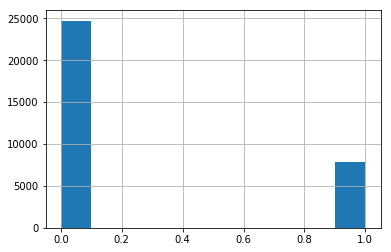

In [9]:
df.Target.hist()

## Validation set
Since we're fitting our model to data, we want to have an unbiased estimate of its performance to help optimise the architecture before we apply the model to the testing data. We can randomly sample a *validation* set from the training data.

In [10]:
_, val_ids = train_test_split(df.index, stratify=df.Target, test_size=0.2, random_state=0)

To help reduce code overhead in the next step, we'll simply set flag in the data for whether or not we want to use each row for training or validation.

In [11]:
df['val'] = 0
df.loc[val_ids, 'val'] = 1

# Feature processing
The data contains both continuous features (real values with numerical comparison) and categorical features (discreet values or string labels with no numerical comparison). Each need to be treated slightly differently.

In [12]:
cat_feats = ['WorkClass', 'Education', 'MaritalStatus', 'Occupation',
             'Relationship', 'Race', 'Gender', 'NativeCountry']
cont_feats = ['Age', 'fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']
train_feats = cont_feats+cat_feats

## Categorical encoding
Our model can only function on numbers, but the categorical features use strings. We can map these string values to integers in order to feed the data into our model. We also want to know whether there are categories which only appear in either training or testing

In [13]:
for feat in ['WorkClass', 'Education', 'MaritalStatus', 'Occupation',
             'Relationship', 'Race', 'Gender', 'NativeCountry']:
    print(feat, set(df[feat]) == set(df_test[feat]))

WorkClass True
Education True
MaritalStatus True
Occupation True
Relationship True
Race True
Gender True
NativeCountry False


In [14]:
print('Missing from test:',  [f for f in set(df.NativeCountry) if f not in set(df_test.NativeCountry)])
print('Missing from train:', [f for f in set(df_test.NativeCountry) if f not in set(df.NativeCountry)])

Missing from test: [' Holand-Netherlands']
Missing from train: []


So, the training data contains an extra country which doesn't appear in the testing data, however the model may well be able to learn things from the extra data which are invarient to country, so we'll keep it in.

We need to ensure the same string --> integer mapping is applied to both training and testing, in order to make sure the data still has the same meaning when we apply the model to the testing data. We'll also construct dictionaries to keep track of the mapping. **N.B.** Pandas has a dedicated column type `Categorical` for helping with this kind of data, but we'll stick with integer mapping for now.

In [15]:
cat_maps = defaultdict(dict)
for feat in ['WorkClass', 'Education', 'MaritalStatus', 'Occupation',
             'Relationship', 'Race', 'Gender', 'NativeCountry']:
    for i, val in enumerate(set(df[feat])):
        cat_maps[feat][val] = i
        df.loc[df[feat] == val, feat] = i
        df_test.loc[df_test[feat] == val, feat] = i

In [16]:
df.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Target,val
0,39,8,77516,2,13,1,12,5,3,1,2174,0,40,22,0,0
1,50,0,83311,2,13,5,3,1,3,1,0,0,13,22,0,0
2,38,2,215646,13,9,3,2,5,3,1,0,0,40,22,0,0
3,53,2,234721,9,7,5,2,1,2,1,0,0,40,22,0,0
4,28,2,338409,2,13,5,1,3,2,0,0,0,40,6,0,0


Looks good, our data now only contains numerical information

## Continuous preprocessing
The weight initialisation we use is optimal for inputs which are unit-Gaussian. The closest we can get is to shift and scale each feature to have mean zero and standard deviation one. `SK-Learn` has `Pipeline` classes to handle series of transformations to data, and we'll use the `StandardScaler` to transform the data.

In [17]:
input_pipe = Pipeline([('norm_in', StandardScaler(with_mean=True, with_std=True))])

Next we need to fit the transformation to the data. Note the Boolean indexing of the data.

In [18]:
input_pipe.fit(df[df.val == 0][cont_feats].values.astype('float32'))

Pipeline(memory=None,
     steps=[('norm_in', StandardScaler(copy=True, with_mean=True, with_std=True))])

And finally apply the transformation to the training, validation, and testing data.

In [19]:
df[cont_feats] = input_pipe.transform(df[cont_feats].values.astype('float32'))
df_test[cont_feats] = input_pipe.transform(df_test[cont_feats].values.astype('float32'))

We can check the transformation by plotting an example feature

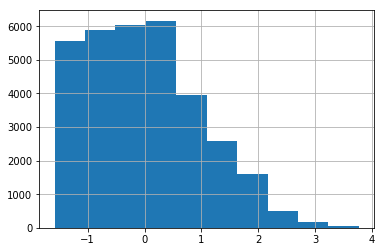

In [20]:
df.Age.hist()

# Embedding 
In the previous notebook, we found that 1-hot encoding categorical features helped to improve performance, however the large increase in inputs to the model, overparameterised it allowing it to severely overfit to the training data.

In *Entity Embeddings of Categorical Variables* ([Guo & Berkhahn, 2016](https://arxiv.org/abs/1604.06737)) a method is presented in which embedding matrices are learnt which allow the categories for each feature to be embedded into a smaller input-space:

Each code (category ID) of a categorical feature corresponds to a row in an $n\times m$ matrix called an *embedding*, where $n$ is the cardinality (number of unique categories) of the feature and $m$ is the pre-chosen *embedding size*, and $m<n$. Effectively, rather than encoding a feature of cardinality $n$ as a one-hot vector of length $n$, it is encoded as a vector of floats of length $m$. The embedding size can be tuned, but useful rule of thumb is min(50, (cardinality+1)//2).

These floats are then treated as parameters of the network meaning they can be updated; effectively, during training the embedding matrix learns the optimal way of representing the feature in a compact fashion whilst still allowing a rich representation of the feature.

In the below example of encoding the day of the week, Monday is represented by (0.3,0.9,0.4,0.7), rather than (1,0,0,0,0,0,0) e.g. by four inputs rather than seven. 
<img src="imgs/embedding.png" width="250">

We can think about this as saying that perhaps it isn;t necessary for the model to knwo exactly which day to the week something happened, but instead whether it occurred in the middle of the week, or at the weekend, say. For our dataset, maybe we don't care about whether the person if from Sweden or Norway, but rather whether they are from a Nordic country. In each case, rather than manually applying grouping the feature categories (prescribing an embedding), we let the model learn the most appropriate embedding for the task.

Building this model will use a hybrid approach of the class and functionally approaches; a `Sequential` model build by the class-based approach can then be used as a transformation in the functional approach.

We build sub-networks for embedding each categorical feature (just the one in our case) and then concatenate the embedding outputs with the continuous inputs.

In [21]:
def get_model(n_cont_in:int, hidden_sizes:List[int], cat_szs:List[int], n_out:int=1, lr:float=1e-3, do:float=0) -> Model:
    #Continuous inputs
    cont_in = Input(shape=(n_cont_in,))
    
    #Categorical embeddings
    embedds = []
    for cat_sz in cat_szs:
        m = Sequential()
        sz = min((cat_sz+1)//2, 50)  # embedding size uses a rule of thumb
        m.add(Embedding(cat_sz, sz, input_length=1))  # Embeddings are normally used of recurrent networks, hence need to specify an input length
        m.add(Reshape(target_shape=(sz,)))  # Need to reshape because reasons
        embedds.append(m)
        
    merged = Concatenate()([cont_in]+[e.output for e in embedds])  # Combine continuous inputs with embeddings
    
    for w in hidden_sizes:  # Pass all inputs through dense layers as normal
        merged = Dense(w, activation='relu', kernel_initializer='he_normal')(merged)
        if do > 0: merged = Dropout(do)(merged)   
    merged = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(merged)
    
    model = Model(inputs=[cont_in]+[e.input for e in embedds], outputs=merged)

    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

In [22]:
cat_szs = [len(set(df[f])) for f in cat_feats]

In [23]:
model = get_model(len(cont_feats), [100, 100], cat_szs, 1, lr=1e-3, do=0)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2_input (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3_input (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_4_input (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_

Note the parameter count of 17,439 compared to the 1-hot encoded model (21,101). We've reduced the required number of parameters by almost 20% and will hopefully still allow the network to access all the required information.

In [24]:
x, y = [df[df.val == 0][cont_feats]]+[df[df.val == 0][f] for f in cat_feats], df[df.val == 0]['Target']
x_val, y_val = [df[df.val == 1][cont_feats]]+[df[df.val == 1][f] for f in cat_feats], df[df.val == 1]['Target']
len(x[0])

26048

In [25]:
def plot_history(hist:History) -> None:
    with sns.axes_style('whitegrid'):
        fig, axs = plt.subplots(1, 2, figsize=(24,8))
        axs[0].plot(range(len(hist.history['loss'])), np.array(hist.history['loss']), label='Training')
        axs[0].plot(range(len(hist.history['val_loss'])), np.array(hist.history['val_loss']), label='Validation')
        axs[1].plot(range(len(hist.history['acc'])), np.array(hist.history['acc']), label='Training')
        axs[1].plot(range(len(hist.history['val_acc'])), np.array(hist.history['val_acc']), label='Validation')

        axs[0].set_ylabel("Loss", fontsize=24)
        axs[1].set_ylabel("Accuracy", fontsize=24)
        for ax in axs:
            ax.legend(fontsize=16)
            ax.set_xlabel("Epoch", fontsize=24)
            ax.tick_params(axis='x', labelsize=16)
            ax.tick_params(axis='y', labelsize=16)
        plt.show()

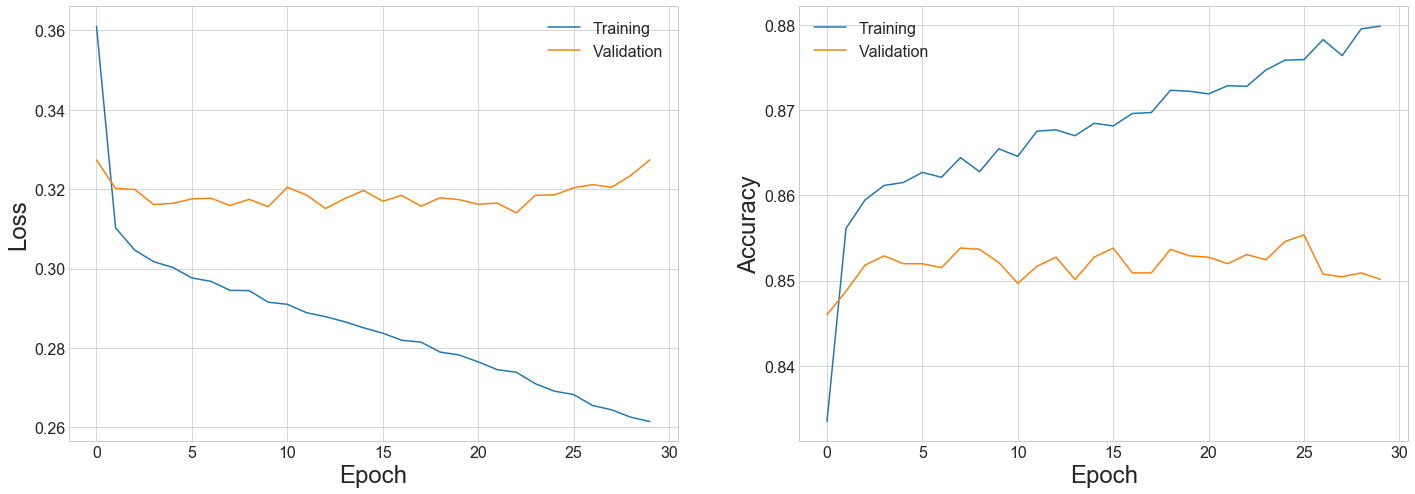

In [26]:
hist = model.fit(x=x, y=y, validation_data=(x_val, y_val), batch_size=128, epochs=30, verbose=0)
plot_history(hist)

Our embedding model achieves about the same performance as the 1-hot encoding model, but without the need for any explicit regularisation.

# Callbacks
[Keras callbacks](https://keras.io/callbacks/) allow us to modify various aspects of the model, optimiser, data, et cetera during training. Many exist and you can even write your own.
We'll look at two common ones: EarlyStopping and ModelCheckpoint.

In [27]:
model = get_model(len(cont_feats), [100, 100], cat_szs, 1, lr=1e-3, do=0)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_9_input (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_10_input (InputLayer) (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_11_input (InputLayer) (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_12_input (InputLayer) (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_

As we've seen, training a network normally involves three stages: undertraining, where performance on training and validation data is bad but improving; optimal performance, where performance on validation data is as good as it will be; and over training, where performance on training data continues to improve, but validation performance either stays the same or gets worse (generalisation to unseen data worsens).

It's necessary to see this point of overtraining to know that are model has reached and passed its optimal performance (is not underfitting), however we want to use the model in the state it was in when it was performing optimally. To do this we can use `Callback` classes to perform actions during training.

`EarlyStopping` will stop training automatically if the validation loss has not improved for a set number of epochs (its `patience`); we can set a really high value of `epochs` in training to ensure the model over trains, but does not take ages to finish training.

`ModelCheckpoint` will save a copy of the model whenever it improves on the validation data. We can then reload this model after training to get back to the state of optimal performance. 

In [28]:
os.makedirs('tmp', exist_ok=True)
callbacks = [EarlyStopping(patience=5, verbose=True),
             ModelCheckpoint('tmp/best.h5', save_best_only=True, save_weights_only=True, verbose=1)]


Epoch 00001: val_loss improved from inf to 0.32311, saving model to tmp/best.h5

Epoch 00002: val_loss did not improve from 0.32311

Epoch 00003: val_loss improved from 0.32311 to 0.31818, saving model to tmp/best.h5

Epoch 00004: val_loss did not improve from 0.31818

Epoch 00005: val_loss improved from 0.31818 to 0.31739, saving model to tmp/best.h5

Epoch 00006: val_loss improved from 0.31739 to 0.31629, saving model to tmp/best.h5

Epoch 00007: val_loss improved from 0.31629 to 0.31617, saving model to tmp/best.h5

Epoch 00008: val_loss improved from 0.31617 to 0.31576, saving model to tmp/best.h5

Epoch 00009: val_loss did not improve from 0.31576

Epoch 00010: val_loss did not improve from 0.31576

Epoch 00011: val_loss did not improve from 0.31576

Epoch 00012: val_loss did not improve from 0.31576

Epoch 00013: val_loss did not improve from 0.31576
Epoch 00013: early stopping


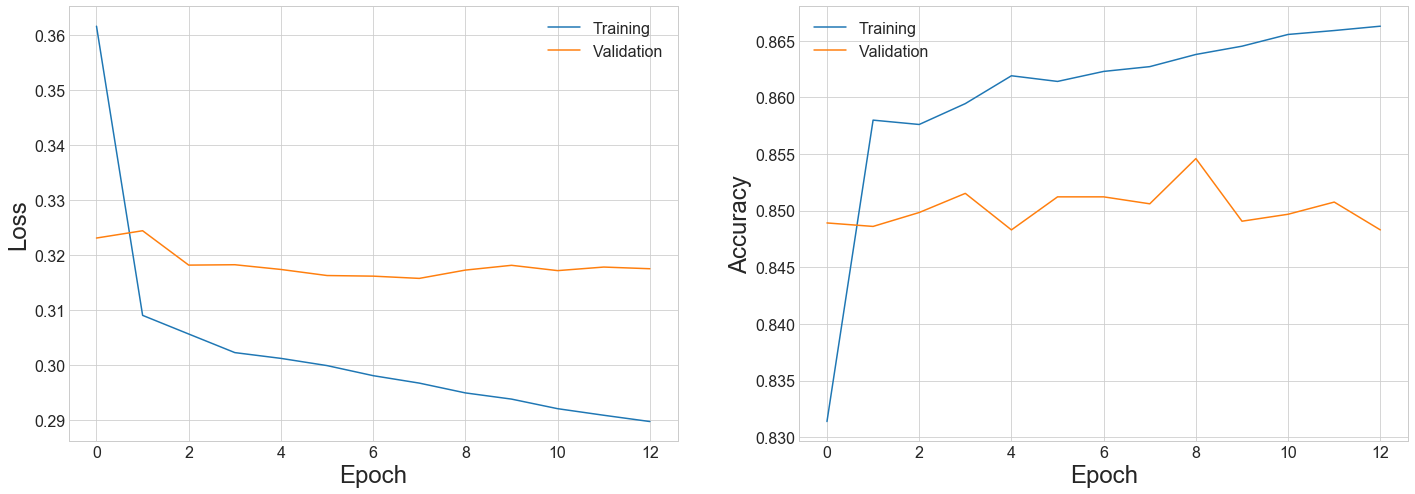

In [29]:
hist = model.fit(x=x, y=y, validation_data=(x_val, y_val), batch_size=128, callbacks=callbacks, epochs=30, verbose=0)
plot_history(hist)
model.load_weights('tmp/best.h5')

Using `Earlystopping` we decreased the traintime of the model by not having to wait to the end, and using the `ModelCheckpoint` we save the model at the point of best performance and then loaded those weights at the end of training.